In [ ]:
#The project is about classification based on people biography in theirs wikipedia article.

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import pandas


from mpl_toolkits.mplot3d import Axes3D


from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

from sklearn.neighbors import NearestNeighbors

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import re


pandas.options.mode.chained_assignment = None #ukrywa warning dotyczący modyfikowania kopii DataFrame

In [3]:
#Reading the data source
wiki = pandas.read_csv('../people_wiki.csv')

In [8]:
#The main idea behind is categorization of people based on key words in the first 20 words in their articles. 

football = ['(football.*?)']
singer = ['(singer.*?)']
    
def decide_tags(string):
    """ Function returns the category based on tag """    
    tags = string.split(' ')[:20]
        
    for tag in tags:

        for regexp in football:
            if re.match(regexp, tag):
                return 'football'
        
        for regexp in singer:
            if re.match(regexp, tag):
                return 'singer'
        
    return "None"


In [9]:
#application ^
wiki['tag'] = wiki['text'].apply(decide_tags)

In [10]:
#We are checking that, numbers of categorized data is good enough for statistic.
classified_person = wiki.loc[wiki['tag'].isin(['singer', 'football']), ]
classified_person.count()


URI     6812
name    6812
text    6812
tag     6812
dtype: int64

In [13]:
#We are making word vectors with TF-IDF method
vectorizer = TfidfVectorizer(token_pattern = r'\b\w+\b',stop_words='english')
matrix = vectorizer.fit_transform(classified_person['text'])

In [14]:
#Kmean should confirms, that number of clusters should be two.
km = KMeans(n_clusters=2, init='k-means++', max_iter=25, n_init=1)
km.fit(matrix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=25,
    n_clusters=2, n_init=1, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [16]:
#Making column with labeled tag
classified_person['tag_kmeans']=km.labels_


In [36]:
#We are finding the cluster, on which kmeans divided our groups
football=classified_person.loc[(classified_person['tag'] == 'football')&(classified_person['tag_kmeans'] == 0)]
singer=classified_person.loc[(classified_person['tag'] == 'singer')&(classified_person['tag_kmeans'] == 0)]


if football['name'].count() > singer['name'].count():
    print("Tag 0 is for footbalist.")
else:
    print("Tag 0 is for singer.")

    
    

Tag 0 is for singer.


In [41]:
football_err=classified_person.loc[(classified_person['tag'] == 'football')&(classified_person['tag_kmeans'] == 0)]
singer_err=classified_person.loc[(classified_person['tag'] == 'singer')&(classified_person['tag_kmeans'] == 1)]


#The error between our "simple" method vs. kmeans
error=(football_err.count()+singer_err.count())/classified_person.count()
print("The error is: {0}".format(error['name']))


The error is: 0.007339988256018791


In [40]:
#prints top ten words in clusters
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(2):
    print("Cluster"+str(i))
    for ind in order_centroids[i, :10]:
        print(str(terms[ind]))
    print('\n')

Top terms per cluster:
Cluster0
album
music
released
song
singer
band
songs
albums
new
film


Cluster1
football
league
season
played
club
team
cup
coach
games
goals




In [44]:
#Calculates distance from center of 0. cluster for whole dataset.
nbrs = NearestNeighbors(n_neighbors=matrix.shape[0],metric='cosine',).fit(matrix)
distances, indices = nbrs.kneighbors(km.cluster_centers_[0].reshape(1,-1))
classified_person['distance_from_0']=distances.reshape(-1,1)

In [46]:
#Calculates distance from center of 1. cluster for whole dataset.
nbrs = NearestNeighbors(n_neighbors=matrix.shape[0],metric='cosine',).fit(matrix)
distances, indices = nbrs.kneighbors(km.cluster_centers_[1].reshape(1,-1))
classified_person['distance_from_1']=distances.reshape(-1,1)

In [50]:
#Shows the persons distance from cluster center of footbalists
classified_person.loc[classified_person['tag_kmeans']==1].sort_values(by=['distance_from_1']).head(5)

,URI,name,text,tag,tag_kmeans,distance_from_0,distance_from_1
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...,football,1,0.652387,0.614532
17,<http://dbpedia.org/resource/Paddy_Dunne_(Gael...,Paddy Dunne (Gaelic footballer),paddy dunne was a gaelic football player from ...,football,1,0.668568,0.634133
21,<http://dbpedia.org/resource/Ceiron_Thomas>,Ceiron Thomas,ceiron thomas born 23 october 1983 is a welsh ...,football,1,0.679692,0.638143
28,<http://dbpedia.org/resource/Leon_Hapgood>,Leon Hapgood,leon duane hapgood born 7 august 1979is an eng...,football,1,0.680773,0.639620
41,<http://dbpedia.org/resource/Bob_Adams_(Americ...,Bob Adams (American football),robert bruce bob adams born august 15 1946 in ...,football,1,0.684764,0.641903


In [54]:
#Shows the persons distance from cluster center of singers
classified_person.loc[classified_person['tag_kmeans']==0].sort_values(by=['distance_from_0']).head(5)

,URI,name,text,tag,tag_kmeans,distance_from_0,distance_from_1
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...,singer,0,0.655767,0.632584
20,<http://dbpedia.org/resource/Chris_Batstone>,Chris Batstone,chris batstone was the 20002002 lead singer of...,singer,0,0.674576,0.637633
29,<http://dbpedia.org/resource/Emily_Osment>,Emily Osment,emily jordan osment born march 10 1992 is an a...,singer,0,0.684671,0.639702
65,<http://dbpedia.org/resource/Susan_Christie>,Susan Christie,susan christie is an american singersongwriter...,singer,0,0.691364,0.644796
81,<http://dbpedia.org/resource/Judi_Silvano>,Judi Silvano,judi silvano born 1951 is a jazz singer and co...,singer,0,0.692507,0.647261


In [59]:
#Used PCA for visualisation
from sklearn.decomposition import PCA
reduced_3Ddata = PCA(n_components=2).fit_transform(matrix.todense())


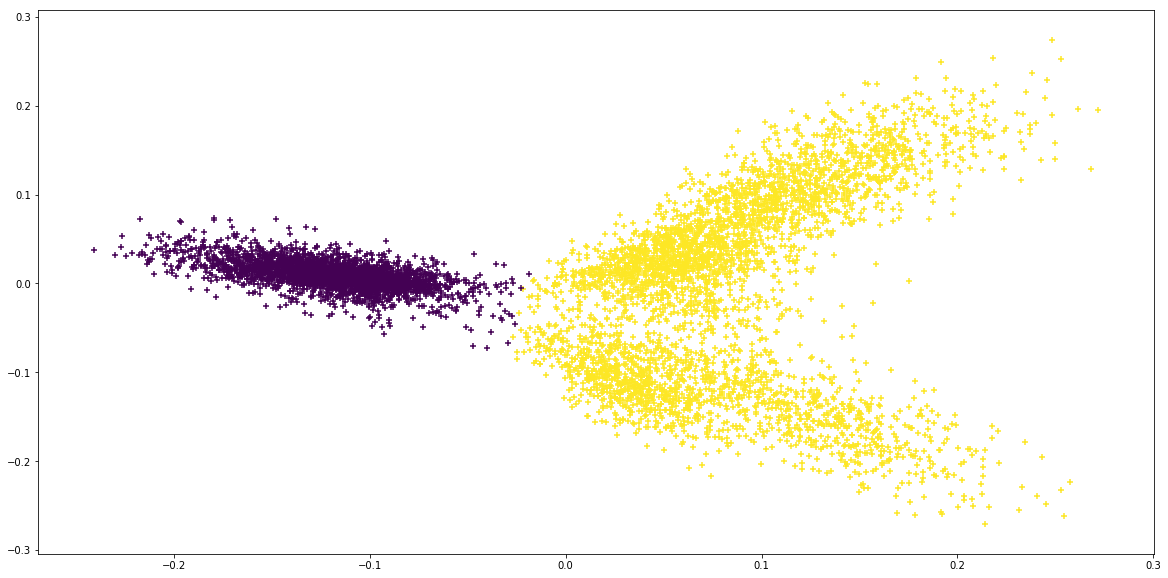

In [66]:
#Diagram shows, that on the left (purple cluster) are singers and in the yellow clusters are footbalists
#Also diagram shows, that we have 1 additional cluster (see yellow cluster)

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111,)


ax.scatter(reduced_data[:,0], reduced_data[:,1],c=classified_person.tag_kmeans[:],  marker='+')
plt.show()
#ax.scatter(centers2D[:,0], centers2D[:,1],centers2D[:,2],marker='x',c='r',s=100)

In [92]:
#Kmean should confirms, that number of clusters should be 3.
km = KMeans(n_clusters=3, init='k-means++', max_iter=25, n_init=1)
km.fit(matrix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=25,
    n_clusters=3, n_init=1, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [93]:
#Making column with labeled tag
classified_person['tag_kmeans']=km.labels_


In [94]:
#We are finding the cluster, on which kmeans divided our groups
football=classified_person.loc[(classified_person['tag'] == 'football')&(classified_person['tag_kmeans'].isin([0,2]))]
singer=classified_person.loc[(classified_person['tag'] == 'singer')&(classified_person['tag_kmeans'].isin([1]))]


if football['name'].count() > singer['name'].count():
    print("Tag 0 is for footbalist.")
else:
    print("Tag 0 is for singer.")

    

Tag 0 is for footbalist.


In [95]:
football_err=classified_person.loc[(classified_person['tag'] == 'football')&(classified_person['tag_kmeans'].isin([1]))]
singer_err=classified_person.loc[(classified_person['tag'] == 'singer')&(classified_person['tag_kmeans'].isin([0,2]))]


#The error between our "simple" method vs. kmeans
error=(football_err.count()+singer_err.count())/classified_person.count()
print("The error is: {0}".format(error['name']))


The error is: 0.007046388725778039


In [96]:
#prints top ten words in clusters
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(3):
    print("Cluster"+str(i))
    for ind in order_centroids[i, :10]:
        print(str(terms[ind]))
    print('\n')

Top terms per cluster:
Cluster0
football
league
season
team
played
club
cup
coach
united
career


Cluster1
album
music
released
song
singer
band
songs
albums
new
film


Cluster2
australian
afl
football
season
played
club
melbourne
rules
games
adelaide




In [97]:
#Calculates distance from center of 0. cluster for whole dataset.
nbrs = NearestNeighbors(n_neighbors=matrix.shape[0],metric='cosine',).fit(matrix)
distances, indices = nbrs.kneighbors(km.cluster_centers_[0].reshape(1,-1))
classified_person['distance_from_0']=distances.reshape(-1,1)

In [98]:
#Calculates distance from center of 1. cluster for whole dataset.
nbrs = NearestNeighbors(n_neighbors=matrix.shape[0],metric='cosine',).fit(matrix)
distances, indices = nbrs.kneighbors(km.cluster_centers_[1].reshape(1,-1))
classified_person['distance_from_1']=distances.reshape(-1,1)

In [99]:
#Calculates distance from center of 2. cluster for whole dataset.
nbrs = NearestNeighbors(n_neighbors=matrix.shape[0],metric='cosine',).fit(matrix)
distances, indices = nbrs.kneighbors(km.cluster_centers_[2].reshape(1,-1))
classified_person['distance_from_2']=distances.reshape(-1,1)

In [100]:
#Shows the persons distance from cluster center of footbalists
classified_person.loc[classified_person['tag_kmeans']==1].sort_values(by=['distance_from_1']).head(5)

,URI,name,text,tag,tag_kmeans,distance_from_0,distance_from_1,distance_from_2
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...,singer,1,0.623733,0.655717,0.494510
20,<http://dbpedia.org/resource/Chris_Batstone>,Chris Batstone,chris batstone was the 20002002 lead singer of...,singer,1,0.625519,0.674501,0.514139
29,<http://dbpedia.org/resource/Emily_Osment>,Emily Osment,emily jordan osment born march 10 1992 is an a...,singer,1,0.632789,0.684588,0.532400
65,<http://dbpedia.org/resource/Susan_Christie>,Susan Christie,susan christie is an american singersongwriter...,singer,1,0.638865,0.691307,0.547937
81,<http://dbpedia.org/resource/Judi_Silvano>,Judi Silvano,judi silvano born 1951 is a jazz singer and co...,singer,1,0.640783,0.692480,0.552027


In [101]:
#Shows the persons distance from cluster center of singers
classified_person.loc[classified_person['tag_kmeans']==0].sort_values(by=['distance_from_0']).head(5)

,URI,name,text,tag,tag_kmeans,distance_from_0,distance_from_1,distance_from_2
17,<http://dbpedia.org/resource/Paddy_Dunne_(Gael...,Paddy Dunne (Gaelic footballer),paddy dunne was a gaelic football player from ...,football,0,0.625484,0.668515,0.500084
21,<http://dbpedia.org/resource/Ceiron_Thomas>,Ceiron Thomas,ceiron thomas born 23 october 1983 is a welsh ...,football,0,0.629827,0.679693,0.519481
28,<http://dbpedia.org/resource/Leon_Hapgood>,Leon Hapgood,leon duane hapgood born 7 august 1979is an eng...,football,0,0.630591,0.680707,0.522220
41,<http://dbpedia.org/resource/Bob_Adams_(Americ...,Bob Adams (American football),robert bruce bob adams born august 15 1946 in ...,football,0,0.632987,0.684704,0.540506
48,<http://dbpedia.org/resource/Marc_Logan>,Marc Logan,marc anthony logan born may 9 1965 is a former...,football,0,0.635631,0.690684,0.541310


In [102]:
#Used PCA for visualisation
from sklearn.decomposition import PCA
reduced_data = PCA(n_components=2).fit_transform(matrix.todense())


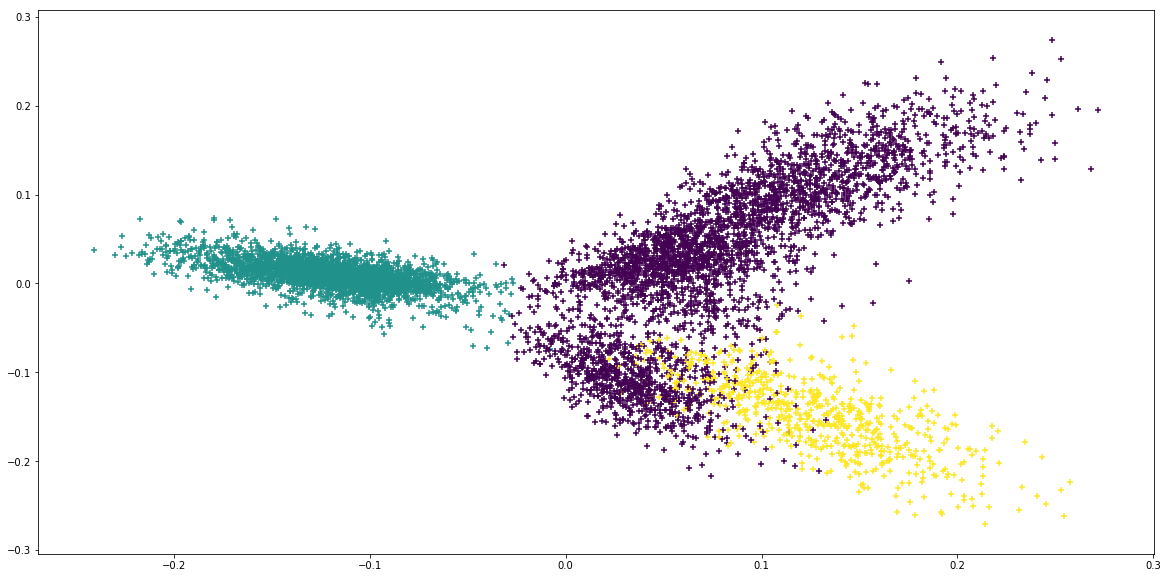

In [103]:
#Diagram shows, that on the left (purple cluster) are singers and in the yellow clusters are footbalists
#Also diagram shows, that we have 1 additional cluster (see yellow cluster)

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111,)


ax.scatter(reduced_data[:,0], reduced_data[:,1],c=classified_person.tag_kmeans[:],  marker='+')
plt.show()
#ax.scatter(centers2D[:,0], centers2D[:,1],centers2D[:,2],marker='x',c='r',s=100)

In [107]:
#Used PCA for visualisation
from sklearn.decomposition import PCA
reduced_3Ddata = PCA(n_components=3).fit_transform(matrix.todense())

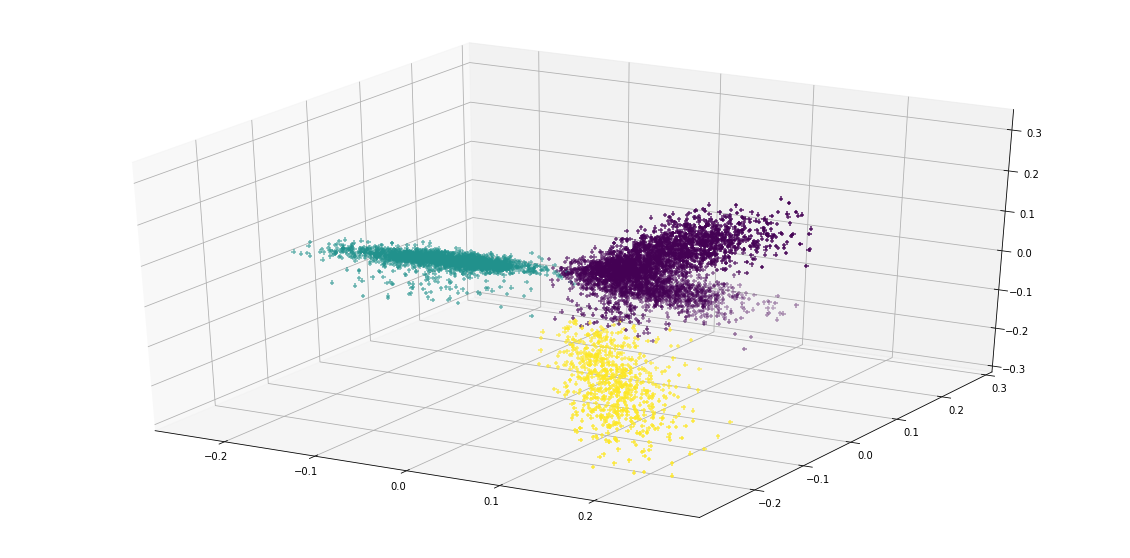

In [108]:
from mpl_toolkits.mplot3d import Axes3D
#a= plt.figure(figsize=(20,10))

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(reduced_3Ddata[:,0], reduced_3Ddata[:,1],reduced_3Ddata[:,2],c=classified_person.tag_kmeans[:], zdir='y', marker='+')
